# 1. Install Dependencies

In [9]:
%pip install gymnasium
%pip install 'gymnasium[atari]'
%pip install 'gymnasium[accept-rom-license]'
%pip install 'shimmy>=0.2.1'
%pip install torch torchvision torchaudio
%pip install matplotlib
%pip install tensorboard
%pip install 'stable-baselines3[extra]>=2.0.0a4'
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached AutoROM-0.4.2-py3-none-any.whl (16 kB)
  Attempting uninstall: autorom
    Found existing installation: AutoROM 0.6.1
    Uninstalling AutoROM-0.6.1:
      Successfully uninstalled AutoROM-0.6.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Attempting uninstall: autorom
    Found existing installation: AutoROM 0.4.2
    Uninstalling AutoROM-0.4.2:
      Successfully uninstalled AutoROM-0.4.2
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/

# 2. Import Dependencies

In [10]:
import gymnasium
from gymnasium import spaces
from gymnasium.spaces import Box

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import clear_output

import time
import numpy as np
from skimage.transform import resize

import torch
from torch import Tensor

from models.models import UndergroundModel

from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# 3. Utils

In [11]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        #print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")
        print(f"Comulative Reward: {experience['com_reward']}")
        
        # Pause animation
        time.sleep(time_lag)

In [12]:
def store_episode_as_gif(experience_buffer, filepath='animation.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 300  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(filepath, writer='imagemagick', fps=fps)

# 4. Create Base Environment

In [13]:
base_env = gymnasium.make('ALE/Pitfall-ram-v5', render_mode='rgb_array')
if base_env.reset():
    print('Environment is ready!')

Environment is ready!


State space: Box(0, 255, (128,), uint8)
Action space: Discrete(18)
Action space: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']
Action: 16
Reward: 0.0
State done :False
State info :{'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}


/home/rubensas/anaconda3/envs/MEI_SI/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


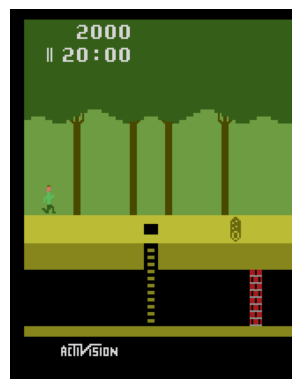

In [14]:
def show_env_info(env):
    # Print dimensions of state and action space
    print("State space: {}".format(base_env.observation_space))
    print(f"Action space: {env.action_space}")
    print(f"Action space: {env.unwrapped.get_action_meanings()}")

    # Sample random action
    action =env.action_space.sample()
    print("Action: {}".format(action))
    next_state, reward, done, _, info = env.step(action)

    # Print output
    print("Reward: {}".format(reward))
    print(f"State done :{done}")
    print(f"State info :{info}")

    # Render and plot an environment frame
    frame = env.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()

show_env_info(base_env)

# 5. Customize Environment

In [15]:
underground_model = UndergroundModel()
underground_model.load_state_dict(torch.load('models/model.h5'))
underground_model.eval()

UndergroundModel(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7744, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [16]:
class CustomEnv(gymnasium.Wrapper):

    def __init__(self, env, model):
        super(CustomEnv, self).__init__(env)
        self.env = env
        self.model = model
        self.lives = 3
        self.last_room = None
        self.is_zero_before = False
        self.n_zeros_before = 0
        self.observation_space = Box(shape=(130,130,3), low=int(0), high=int(255))
        
    def calculate_mse(self, img1, img2):
        np_image1 = np.array(img1)
        np_image2 = np.array(img2)
        mse = np.mean((np_image1 - np_image2) ** 2)
        return mse

    def step(self, action):
        next_state_ram, reward, done, truncated, info = self.env.step(action)
        self.lives = info['lives']

        # TODO: Resize image to 130x130 and convert to grayscale
        next_state_img = self.env.render()
        next_state_img = resize(next_state_img,(130,130))
        underground_prediction = self.make_underground_prediction(next_state_img)
        if underground_prediction == 1:
            reward -= 1

        # Try to detect death ASAP
        mse_score = None
        if self.last_room is not None:
            mse_score = self.calculate_mse(self.last_room, next_state_img)
            if mse_score == 0:
                if self.is_zero_before and self.n_zeros_before > 5:
                    reward -= 100
                    self.n_zeros_before = -9999
                
                self.is_zero_before = True
                self.n_zeros_before += 1
                
            else:
                self.is_zero_before = False
                self.n_zeros_before = 0
        
        self.last_room = next_state_img
        return next_state_img, reward, done, truncated, info

    def reset(self,seed=None):
        if seed:
            _,info = self.env.reset(seed=seed)
        else:
            _,info = self.env.reset()
        img = self.env.render()
        img = resize(img,(130,130))
        return (img,info)
        

    def make_underground_prediction(self, img):
        '''Checks if player is underground'''
        img = self.preprocessar(img)
        img = img.astype(np.float32)
        img = Tensor(img)
        img = img.reshape(1,3,130,130)
        pred = self.model(img)
        pred = pred.detach().cpu().detach().numpy()[0].argmax()
        return pred

    def preprocessar(self,imagem):
        imagem = np.array(imagem)
        data_mean = np.mean(imagem)
        data_std = np.std(imagem)
        imagem = (imagem - data_mean) / data_std
        xmax, xmin = imagem.max(), imagem.min()
        imagem = (imagem - xmin)/(xmax - xmin)
        imagem = imagem.transpose(2,1,0)
        return imagem

env = CustomEnv(base_env, underground_model)
if env.reset():
    print('Custom Environment is ready!')

Custom Environment is ready!


# 6. Custom Model: Define and Train

In [17]:
# Print action space and number of actions
n_actions = env.action_space.n
actions = env.unwrapped.get_action_meanings()
print(f"Number of actions: {n_actions}, Actions: {actions}")

Number of actions: 18, Actions: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [27]:
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Flatten(),
        )
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]


        self.linear = torch.nn.Sequential(
            torch.nn.Linear(n_flatten, features_dim),
            torch.nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))


In [28]:
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [29]:
class TensorboardCallback(BaseCallback):
    def __init__(self, log_dir, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
        self.writer = SummaryWriter(log_dir=log_dir)

    def _on_step(self) -> bool:
        # Log training metrics
        self.writer.add_scalar("Loss", self.locals["values"].item(), self.num_timesteps)
        self.writer.add_scalar("Reward", self.locals["rewards"][0], self.num_timesteps)

        return True

    def _on_training_end(self) -> None:
        # Close the SummaryWriter after training
        self.writer.close()

# Specify the log directory where TensorBoard files will be saved
log_dir = "logs/"

# Create a TensorboardCallback
tensorboard_callback = TensorboardCallback(log_dir=log_dir)

In [30]:
# Train the agent
model.learn(total_timesteps=100, callback=tensorboard_callback)

# Save the model
model.save("models/(local) ppo_pitfall")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 663      |
|    ep_rew_mean     | -394     |
| time/              |          |
|    fps             | 47       |
|    iterations      | 1        |
|    time_elapsed    | 42       |
|    total_timesteps | 2048     |
---------------------------------


# 7. Test Model

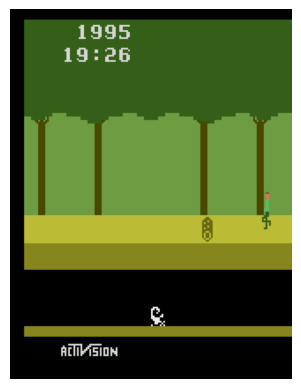

Episode: 2348/2348
Epoch: 2/2
Action: 9
Reward: 0.0
Comulative Reward: -260.0
MSE Score: 0.0001885045387592731


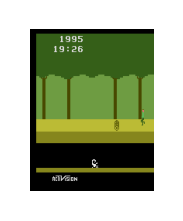

In [31]:
# Start by loading the model
model = PPO.load("models/(local) ppo_pitfall")

experience_buffer = []
obs = env.reset()[0]
com_reward = 0
terminated = False
epoch = 0

start_time = time.time()

while epoch <= 1:
    epoch += 1
    while not terminated:
        action, _ = model.predict(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        com_reward += reward

        experience_buffer.append({
            'episode': info['episode_frame_number'],
            'epoch': epoch,
            'frame': env.render(),
            'action': action,
            'reward': reward,
            'state': obs,
            'com_reward': com_reward,
        })
        
        obs = next_obs
        
        if time.time() - start_time > 10:
            break

run_animation(experience_buffer)
store_episode_as_gif(experience_buffer, filepath='animation.gif')